In [1]:
from utils import *
from normalizers import *
from FLPO import *
from viz import *
from UAV_Net import UAV_Net
from annealing import anneal
import pickle

In [2]:
drones = [
    ((10.0, 5.0), (45.0, 50.0), 1.0),  # Long distance, high charge
    ((3.0, 40.0), (50.0, 10.0), 1.0),  # Long distance, medium charge
    ((20.0, 15.0), (35.0, 35.0), 1.0),  # Moderate distance, medium charge
    ((5.0, 30.0), (25.0, 5.0), 1.0),  # Moderate distance, low charge
    ((40.0, 45.0), (10.0, 10.0), 1.0),  # Long distance, high charge
    ((30.0, 20.0), (5.0, 35.0), 1.0),  # Moderate distance, medium charge
    ((15.0, 10.0), (40.0, 40.0), 1.0),  # Moderate distance, low charge
    ((35.0, 5.0), (10.0, 45.0), 1.0),  # Long distance, medium charge
    ((25.0, 40.0), (20.0, 10.0), 1.0),  # Moderate distance, high charge
    ((45.0, 15.0), (5.0, 20.0), 1.0),  # Long distance, low charge
]
N_stations = 5
init_ugv = np.repeat(
    np.array(
        [
            [0.5, 0.9],
        ]
    ),
    N_stations,
    axis=0,
)
fcr = 15.0  # Full Charge Range
ugv_factor = 0.0  # the cost factor for UGV transportation
distance = "euclidean"  # distance measure in the environment
blocks = None # for benchmark we ignore blocks


# FLPO Algorithm

In [3]:
beta_init = 1e-4  # initial beta value for the optimization.
beta_f = 1e4  # final beta value for the optimization
alpha = 2.0  # beta growth rate
purturb = 1e-6  # random purturbation in optimization

uav_net = UAV_Net(drones, N_stations, init_ugv, blocks, ugv_factor, fcr, distance)
obj = uav_net.objective
Y_s, Betas = anneal(
    obj,
    uav_net.stations,
    uav_net.bounds,
    beta_init,
    beta_f,
    alpha,
    purturb,
    "powell",
    True,
)

UAV Network was successfully created.
Beta: 1.00e-04  F.E.: -7.43145e+05
Beta: 2.00e-04  F.E.: -3.71060e+05
Beta: 4.00e-04  F.E.: -1.85014e+05
Beta: 8.00e-04  F.E.: -9.19907e+04
Beta: 1.60e-03  F.E.: -4.54799e+04
Beta: 3.20e-03  F.E.: -2.22257e+04
Beta: 6.40e-03  F.E.: -1.06013e+04
Beta: 1.28e-02  F.E.: -4.80580e+03
Beta: 2.56e-02  F.E.: -1.99395e+03
Beta: 5.12e-02  F.E.: -6.82847e+02
Beta: 1.02e-01  F.E.: -2.26923e+02
Beta: 2.05e-01  F.E.: -5.55307e+01
Beta: 4.10e-01  F.E.: 8.24480e+01
Beta: 8.19e-01  F.E.: 7.74385e+01
Beta: 1.64e+00  F.E.: 1.57208e+02
Beta: 3.28e+00  F.E.: 1.83524e+02
Beta: 6.55e+00  F.E.: 1.89773e+02
Beta: 1.31e+01  F.E.: 9.43206e+00
Beta: 2.62e+01  F.E.: 9.47206e+00
Beta: 5.24e+01  F.E.: 9.49864e+00
Beta: 1.05e+02  F.E.: 9.49843e+00
--Optimization Terminated--
Elapsed time: 11.61




Drone 1 --->f2 --->f1 --->f3 --->[D1]
Drone 2 --->f4 --->f1 --->f5 --->[D2]
Drone 3 --->f2 --->f1 --->[D3]
Drone 4 --->f4 --->f1 --->f2 --->[D4]
Drone 5 --->f3 --->f1 --->f2 --->[D5]
Drone 6 --->f1 --->f4 --->[D6]
Drone 7 --->f2 --->f1 --->f3 --->[D7]
Drone 8 --->f5 --->f1 --->f4 --->[D8]
Drone 9 --->f1 --->f2 --->[D9]
Drone 10 --->f5 --->f1 --->f4 --->[D10]

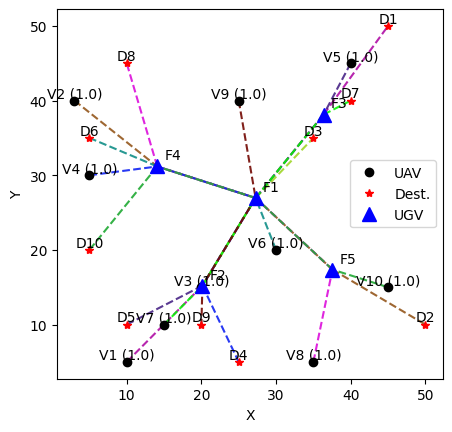

In [4]:
from matplotlib import pyplot as plt
uav_net.return_stagewise_cost(Y_s[-1], Betas[-1])
P_ss = calc_associations(uav_net.D_ss, Betas[-1])
routes = calc_routs(P_ss)
print_routs(routes, N_stations)
scale = uav_net.ub - uav_net.lb
drift = uav_net.lb
f_s = Y_s[-1] * scale + drift
plot_drone_routes(
    drones, f_s, blocks, routes, fcr, ugv_factor, ugv_init_loc=None, save_=False
)

In [5]:
uav_net.return_total_cost()

446.42644134047845

# GUROBI

In [6]:
s = np.array([ [list(start)] for start, _, _ in drones ]) / 47.0
e = np.array([ [list(end)] for _, end, _ in drones ]) / 47.0
num_nodes = N_stations
num_agents = len(drones)
T = num_nodes + 1
dim_ = 2
F_base = init_ugv.copy()
threshold = fcr / 47.0


In [7]:
from GurobiSolver import SolveMIP

gap = 0.0
best_y, best_eta, cost, elapsed_time = SolveMIP(
    s,
    e,
    num_agents,
    num_nodes,
    T,
    dim_,
    threshold=threshold,
    y_init=None,
    gap=gap,
)

Set parameter Username
Academic license - for non-commercial use only - expires 2026-07-28
Read LP format model from file C:\Users\salar\AppData\Local\Temp\tmphiv_6gmv.pyomo.lp
Reading time = 0.00 seconds
x1: 228 rows, 550 columns, 844 nonzeros
Set parameter NonConvex to value 2
Set parameter MIPGap to value 0
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13620H, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 228 rows, 550 columns and 844 nonzeros
Model fingerprint: 0x0f1ab7e6
Model has 180 quadratic constraints
Variable types: 190 continuous, 360 integer (360 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e-01, 1e+00]
  Objective range  [1e-01, 1e-01]
  Bounds range     [5e-02, 1e+00]
  RHS range        [3e-01, 1e+00]
  QRHS range       [6e-02, 1e+0

In [8]:
cost * 47 * num_agents

434.08870608929124

In [9]:
elapsed_time

37.74696373939514